In [1]:
# import seaborn as sns
# import numpy as np
# from sklearn.model_selection import train_test_split
# import matplotlib
# from tqdm import tqdm
# import torch

# sns.set_style("darkgrid")

# from sklearn.datasets import make_classification
# import matplotlib.pyplot as plt

In [2]:
# separable = False
# while not separable:
#     samples = make_classification(n_samples=1000,n_features=2,n_redundant=0,n_informative=1,n_clusters_per_class=1,flip_y=-1)
#     red = samples[0][samples[1] == 0]
#     blue = samples[0][samples[1] == 1]
#     separable = any([red[:,k].max() < blue[:,k].min() or red[:,k].min() > blue[:,k].max() for k in range(2)])
    

In [3]:
# red_labels = np.zeros(len(red))
# blue_labels = np.ones(len(blue))

In [4]:
# labels = np.append(red_labels,blue_labels)
# inputs = np.concatenate((red,blue),axis=0)

In [5]:
# X_train, X_test,y_train,y_test = train_test_split(inputs, labels,test_size=0.33,random_state= 42)

In [6]:
# class LogisticRegression(torch.nn.Module):
#     def __init__(self,input_dim,output_dim):
#         super(LogisticRegression,self).__init__()
#         self.linear = torch.nn.Linear(input_dim,output_dim)
    
#     def forward(self,x):
#         outputs = torch.sigmoid(self.linear(x))
#         return outputs

In [7]:
# epochs = 200000
# input_dim = 2
# output_dim = 1
# learning_rate = 0.01

# model = LogisticRegression(input_dim,output_dim)

# criterion = torch.nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

# X_train,X_test = torch.Tensor(X_train),torch.Tensor(X_test)
# y_train,y_test = torch.Tensor(y_train),torch.Tensor(y_test)

In [8]:
# losses =[]
# losses_test = []
# Iterations = []
# iter = 0
# for epoch in tqdm(range(int(epochs)), desc='Training Epochs'):
#     x = X_train
#     labels = y_train
#     optimizer.zero_grad()
#     outputs = model(X_train)
#     loss = criterion(torch.squeeze(outputs),labels)
#     loss.backward()
#     optimizer.step()
#     iter+= 1
    
#     if iter%10000 == 0:
#         with torch.no_grad():
#             correct_test = 0
#             total_test = 0
#             outputs_test = torch.squeeze(model(X_test))
#             loss_test = criterion(outputs_test,y_test)
#             predicted_test= outputs_test.round().detach().numpy()
#             total_test += y_test.size(0)
#             correct_test += np.sum(predicted_test == y_test.detach().numpy())
#             accuracy_test = 100 * correct_test/total_test
#             losses_test.append(loss_test.item())
            
#             total = 0
#             correct = 0
#             total += y_train.size(0)
#             correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
#             accuracy = 100 * correct/total
#             losses.append(loss.item())
#             Iterations.append(iter)
            
#             print(f"Iteration: {iter}. \n Test - Loss: {loss_test.item()}.Accuracy:{accuracy_test}")
#             print(f"Train - Loss: {loss.item()}. Accuracy:{accuracy}\n")
        

In [9]:
# def model_plot(model,X,y,title):
#     parm = {}
#     b = []
#     for name,param in model.named_parameters():
#         parm[name] = param.detach().numpy()
    
#     w = parm['linear.weight'][0]
#     b = parm['linear.bias'][0]
#     plt.scatter(X[:,0],X[:,1],c=y,cmap='jet')
#     u = np.linspace(X[:,0].min(),X[:,0].max(),2)
#     plt.plot(u, (0.5-b-w[0] * u)/w[1])
#     plt.xlim(X[:,0].min()-0.5, X[:,0].max() + 0.5)
#     plt.ylim(X[:,1].min() - 0.5, X[:,1].max() + 0.5)
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title(title)
#     plt.show()

In [10]:
# model_plot(model,X_train,y_train,'Train Data')

In [11]:
# model_plot(model,X_test,y_test,'Test data')

In [12]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets,models,transforms
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/thrilok/miniforge3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
# download the data
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2022-04-16 18:30:49--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.63.55, 13.32.63.112, 13.32.63.6, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.63.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  41.9MB/s    in 1.1s    

2022-04-16 18:30:50 (41.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/

  inflating: hymenoptera_data/train/bees/2031225713_50ed499635.jpg  
  inflating: hymenoptera_data/train/bees/2037437624_2d7bce461f.jpg  
  inflating: hymenoptera_data/train/bees/2053200300_8911ef438a.jpg  
  inflating: hymenoptera_data/train/bees/205835650_e6f2614bee.jpg  
  inflating: hymenoptera_data/train/bees/208702903_42fb4d9748.jpg  
  inflating: hymenoptera_data/train/bees/21399619_3e61e5bb6f.jpg  
  inflating: hymenoptera_data/train/bees/2227611847_ec72d40403.jpg  
  inflating: hymenoptera_data/train/bees/2321139806_d73d899e66.jpg  
  inflating: hymenoptera_data/train/bees/2330918208_8074770c20.jpg  
  inflating: hymenoptera_data/train/bees/2345177635_caf07159b3.jpg  
  inflating: hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg  
  inflating: hymenoptera_data/train/bees/2364597044_3c3e3fc391.jpg  
  inflating: hymenoptera_data/train/bees/2384149906_2cd8b0b699.jpg  
  inflating: hymenoptera_data/train/bees/2397446847_04ef3cd3e1.jpg  
  inflating: hymenoptera_data/train/be

  inflating: hymenoptera_data/val/ants/2255445811_dabcdf7258.jpg  
  inflating: hymenoptera_data/val/ants/239161491_86ac23b0a3.jpg  
  inflating: hymenoptera_data/val/ants/263615709_cfb28f6b8e.jpg  
  inflating: hymenoptera_data/val/ants/308196310_1db5ffa01b.jpg  
  inflating: hymenoptera_data/val/ants/319494379_648fb5a1c6.jpg  
  inflating: hymenoptera_data/val/ants/35558229_1fa4608a7a.jpg  
  inflating: hymenoptera_data/val/ants/412436937_4c2378efc2.jpg  
  inflating: hymenoptera_data/val/ants/436944325_d4925a38c7.jpg  
  inflating: hymenoptera_data/val/ants/445356866_6cb3289067.jpg  
  inflating: hymenoptera_data/val/ants/459442412_412fecf3fe.jpg  
  inflating: hymenoptera_data/val/ants/470127071_8b8ee2bd74.jpg  
  inflating: hymenoptera_data/val/ants/477437164_bc3e6e594a.jpg  
  inflating: hymenoptera_data/val/ants/488272201_c5aa281348.jpg  
  inflating: hymenoptera_data/val/ants/502717153_3e4865621a.jpg  
  inflating: hymenoptera_data/val/ants/518746016_bcc28f8b5b.jpg  
  inflatin

In [15]:
data_dir = 'hymenoptera_data'

class ReshapeTransform:
    def __init__(self,new_size):
        self.new_size = new_size
    
    def __call__(self,img):
        result = torch.reshape(img,self.new_size)
        return result

data_transforms = {
    'train':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,))
    ]),
    'val':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,))
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                 for x in ['train','val']}

train_dataset = torch.utils.data.DataLoader(image_datasets['train'],
                                            batch_size=len(image_datasets['train']),
                                            shuffle=True)
test_dataset = torch.utils.data.DataLoader(image_datasets['val'],
                                           batch_size=len(image_datasets['val']),
                                           shuffle=True)

In [16]:
len(image_datasets['train']),len(image_datasets['val'])

(244, 153)

Dimension of image: torch.Size([244, 150528]) 
 Dimension of labels: torch.Size([244])


/var/folders/4d/gx0lrt1n0l34spb_k9cnkfpr0000gn/T/ipykernel_3452/3087531247.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804319176/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  plt.imshow(x[160].reshape(1,3,224,224).squeeze().T.numpy())


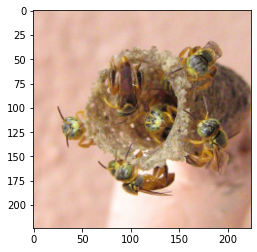

In [17]:
x,y = next(iter(train_dataset))

dim = x.shape[1]
print("Dimension of image:",x.shape,"\n",
     "Dimension of labels:",y.shape)
plt.imshow(x[160].reshape(1,3,224,224).squeeze().T.numpy())

In [18]:
class LR(nn.Module):
    def __init__(self,dim,lr = torch.scalar_tensor(0.01)):
        super(LR,self).__init__()
        
        self.w = torch.zeros(dim, 1, dtype=torch.float).to(device)
        self.b = torch.scalar_tensor(0).to(device)
        self.grads = {"dw": torch.zeros(dim,1,dtype=torch.float).to(device),
                     "db":torch.scalar_tensor(0).to(device)}
        self.lr = lr.to(device)
    
    def forward(self,x):
        
        z = torch.mm(self.w.T,x) + self.b
        a = self.sigmoid(z)
        return a
    
    def sigmoid(self,z):
        return 1/(1 + torch.exp(-z))
    
    def backward(self, x, yhat, y):
        
        self.grads["dw"] = (1/x.shape[1]) * torch.mm(x, (yhat - y).T)
        self.grads["db"] = (1/x.shape[1]) * torch.sum(yhat - y)
    
    def optimize(self):
        
        self.w = self.w - self.lr * self.grads["dw"]
        self.b = self.b - self.lr * self.grads["db"]
        

def loss(yhat, y):
    m = y.size()[1]
    return -(1/m) * torch.sum(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))

def predict(yhat, y):
    y_prediction = torch.zeros(1, y.size()[1])
    for i in range(yhat.size()[1]):
        if yhat[0, i] <= 0.5:
            y_prediction[0, i] = 0
        else:
            y_prediction[0, i] = 1
    return 100 - torch.mean(torch.abs(y_prediction - y)) * 100

In [19]:
x, y = next(iter(train_dataset))

x_flatten = x.T
y = y.unsqueeze(0)

dim = x_flatten.shape[0]

model = LR(dim)
model.to(device)
yhat = model.forward(x_flatten.to(device))
yhat = yhat.data.cpu()

cost = loss(yhat, y)
prediction = predict(yhat, y)
print("cost:", cost)
print("Accuracy:", prediction)

model.backward(x_flatten.to(device), yhat.to(device), y.to(device))
model.optimize()

cost: tensor(0.6931)
Accuracy: tensor(50.4098)


In [20]:
costs = []
dim = x_flatten.shape[0]
learning_rate = torch.scalar_tensor(0.0001).to(device)
num_iterations = 1000
lrmodel = LR(dim, learning_rate)
lrmodel.to(device)

def transform_data(x,y):
    x_flatten = x.T
    y = y.unsqueeze(0)
    return x_flatten, y

for i in range(num_iterations):
    x, y = next(iter(train_dataset))
    test_x, test_y = next(iter(test_dataset))
    x, y = transform_data(x, y)
    test_x, test_y = transform_data(test_x, test_y)
    
    yhat = lrmodel.forward(x.to(device))
    cost = loss(yhat.data.cpu(),y)
    train_pred = predict(yhat, y)
    
    lrmodel.backward(x.to(device),
                    yhat.to(device),
                    y.to(device))
    lrmodel.optimize()
    
    yhat_test = lrmodel.forward(test_x.to(device))
    test_pred = predict(yhat_test, test_y)
    
    if i % 10 == 0:
        costs.append(cost)
    
    if i % 10 == 0:
        print("cost after iteration {}: {} | Train Acc: {} | Test Acc: {}".format(i,cost,train_pred,test_pred))

cost after iteration 0: 0.6931472420692444 | Train Acc: 50.40983581542969 | Test Acc: 45.75163269042969
cost after iteration 10: 0.6691471338272095 | Train Acc: 64.3442611694336 | Test Acc: 54.24836730957031
cost after iteration 20: 0.6513181924819946 | Train Acc: 68.44261932373047 | Test Acc: 54.24836730957031
cost after iteration 30: 0.6367825269699097 | Train Acc: 68.03278350830078 | Test Acc: 54.24836730957031
cost after iteration 40: 0.6245337724685669 | Train Acc: 69.67213439941406 | Test Acc: 54.90196228027344
cost after iteration 50: 0.6139225363731384 | Train Acc: 70.90164184570312 | Test Acc: 56.20914840698242
cost after iteration 60: 0.6045235395431519 | Train Acc: 72.54098510742188 | Test Acc: 56.86274337768555
cost after iteration 70: 0.5960511565208435 | Train Acc: 74.18032836914062 | Test Acc: 57.51633834838867
cost after iteration 80: 0.5883085131645203 | Train Acc: 73.77049255371094 | Test Acc: 57.51633834838867
cost after iteration 90: 0.5811557173728943 | Train Acc: 

cost after iteration 780: 0.38393643498420715 | Train Acc: 89.75409698486328 | Test Acc: 60.13071823120117
cost after iteration 790: 0.3823661208152771 | Train Acc: 90.16393280029297 | Test Acc: 60.13071823120117
cost after iteration 800: 0.38081130385398865 | Train Acc: 90.57376861572266 | Test Acc: 60.13071823120117
cost after iteration 810: 0.37927165627479553 | Train Acc: 90.98360443115234 | Test Acc: 60.13071823120117
cost after iteration 820: 0.37774696946144104 | Train Acc: 90.98360443115234 | Test Acc: 60.13071823120117
cost after iteration 830: 0.3762368857860565 | Train Acc: 90.98360443115234 | Test Acc: 59.47712326049805
cost after iteration 840: 0.3747411370277405 | Train Acc: 90.98360443115234 | Test Acc: 59.47712326049805
cost after iteration 850: 0.3732595145702362 | Train Acc: 90.98360443115234 | Test Acc: 59.47712326049805
cost after iteration 860: 0.3717917203903198 | Train Acc: 90.98360443115234 | Test Acc: 59.47712326049805
cost after iteration 870: 0.37033745646476

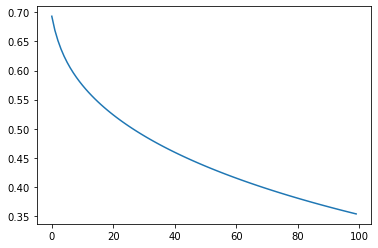

In [21]:
plt.plot(costs)
plt.show()